In [1]:
import os
import ase
import json
import mendeleev
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path as path
from collections import defaultdict
from ase.visualize.plot import plot_atoms
from structure_featurization import featurize, featurize_expanded
from ase import io

In [2]:
def get_gpaw_trajectories(defect_db_path:str):
    res = defaultdict(list)
    for file_ in os.listdir(defect_db_path):
        if not file_.startswith("id"):
            continue
        this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
        for traj_file in os.listdir(this_folder):
            try:
                res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
            except ase.io.formats.UnknownFileTypeError:
                pass
    return res


dataset = get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [3]:
dataset.keys()

dict_keys(['id43', 'id4', 'id34', 'id44', 'id38', 'id12', 'id31', 'id11', 'id22', 'id15', 'id16', 'id9', 'id27', 'id14', 'id7', 'id24', 'id1', 'id37', 'id13', 'id20', 'id35', 'id36', 'id17', 'id6', 'id28', 'id3', 'id45', 'id18', 'id23', 'id21', 'id5', 'id42', 'id46', 'id33', 'id25', 'id26', 'id30', 'id8', 'id19', 'id40', 'id10', 'id41', 'id29', 'id47', 'id39', 'id32', 'id0', 'id2'])

<AxesSubplot:>

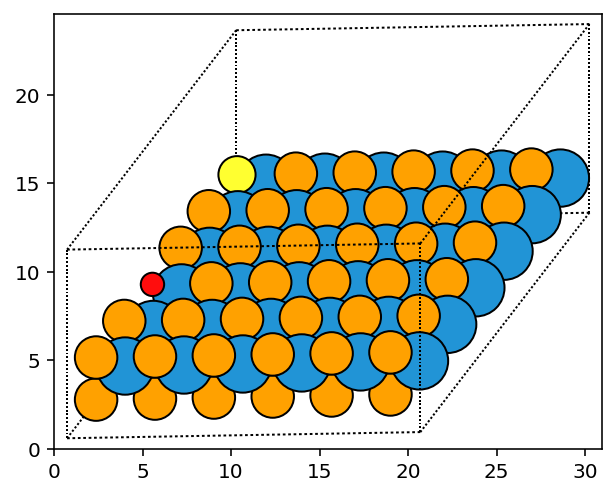

In [17]:
id_prop = []
defect = 'id2'
data_root = path(f'datasets/cgcnn_data_format/{defect}')
data_root.mkdir() if not data_root.exists() else None


def init_atom_feat(atoms: ase.Atom):
    
    def compute_species_params(charge):
        element = mendeleev.element(charge)
        return [charge, element.atomic_volume, element.group_id, element.period]     
    
    atoms_feat = dict()
    for atom, charge in zip(atoms, atoms.get_atomic_numbers()):
        atoms_feat[atom.index] = compute_species_params(int(charge))
        
    return json.dumps(atoms_feat)

matminer_feat = {}
for idx, item in enumerate(dataset[defect][0]):
    # id, target 
    id_prop.append(f'{idx}, {item.get_potential_energy()}\n')
    ase.io.write(data_root.joinpath(f'{idx}.cif'), item, 'cif')
    matminer_feat[idx] = featurize(pymatgen.io.ase.AseAtomsAdaptor.get_structure(item))

with open(data_root.joinpath('id_prop.csv'), 'w') as f:
    f.writelines(id_prop)
with open(data_root.joinpath('atom_init.json'), 'w') as f:
    f.writelines(init_atom_feat(dataset[defect][0][0]))
with open(data_root.joinpath('matminer_feat.json'), 'w') as f:
    f.writelines(json.dumps(matminer_feat))


torch.tensor(list(feat.values())).shape
plot_atoms(dataset[defect][0][0], rotation='135x,1y,1z')


In [4]:
import matplotlib
import pylab

from math import floor, ceil
from random import shuffle
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.data.molecule import MolecularGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule


cm = pylab.get_cmap('Set1')

import tensorflow as tf
import numpy as np

In [5]:
tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

In [6]:
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=6)
# gc = MolecularGraph()
model = MEGNetModel(nfeat_edge=100, nfeat_global=2, graph_converter=gc).from_file('8.9e-4')
# model = MEGNetModel

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
model.load_weights('callback/val_mae_00629_4.502405.hdf5')

In [8]:
mol = []
target = []
color_label = defaultdict(list)
defect_id = []

for i, defect in enumerate(dataset.keys()):
    try:
        data_len = dataset[defect][0].__len__()
        color_label[defect].append([cm(1 * i / data_len) for j in range(data_len)])
        [defect_id.append(defect.strip('id')) for j in range(data_len)]
        for realization in dataset[defect]:
            mol.append(pymatgen.io.ase.AseAtomsAdaptor.get_molecule(realization[0]))
            target.append(realization[-1].get_potential_energy())
    except IndexError:
        print('ops')
        
a = list(zip(mol, target, defect_id))
shuffle(a)
mol, target, defect_id = zip(*a)

print(mol.__len__())

873


In [9]:
train_ratio = 0.75
train_len = ceil(mol.__len__() * train_ratio)
val_len = floor(mol.__len__() * (1 - train_ratio))

train_mol = list(mol[:train_len])
train_target = list(target[:train_len])

val_mol = list(mol[train_len:])
val_target = list(target[train_len:])
# val_color_label = color_label[train_len:]
val_defect_id = defect_id[train_len:]

In [10]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_mol, train_target, is_intensive=INTENSIVE)
model.target_scaler = scaler

In [ ]:
model.train(train_mol, train_target, validation_structures=val_mol, validation_targets=val_target, epochs=5000, verbose=1, patience=1000)#, prev_model='callback/val_mae_00043_0.495604.hdf5')

In [234]:
#model.save_model('8.9e-4')

/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: 8.9e-4/assets


INFO:tensorflow:Assets written to: 8.9e-4/assets


In [11]:
def get_cmap(n, name='gnuplot'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def legend_no_dup_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1,1), ncol=2)

In [12]:
predicted_tests = []

foo = defaultdict(list)
for mol, id, target in zip(val_mol, val_defect_id, val_target):
    pred = model.predict_structure(mol).ravel()[0]
    predicted_tests.append(pred)
    foo[id].append((target, pred))

In [13]:
target = np.array(val_target)
pred = np.array(predicted_tests)

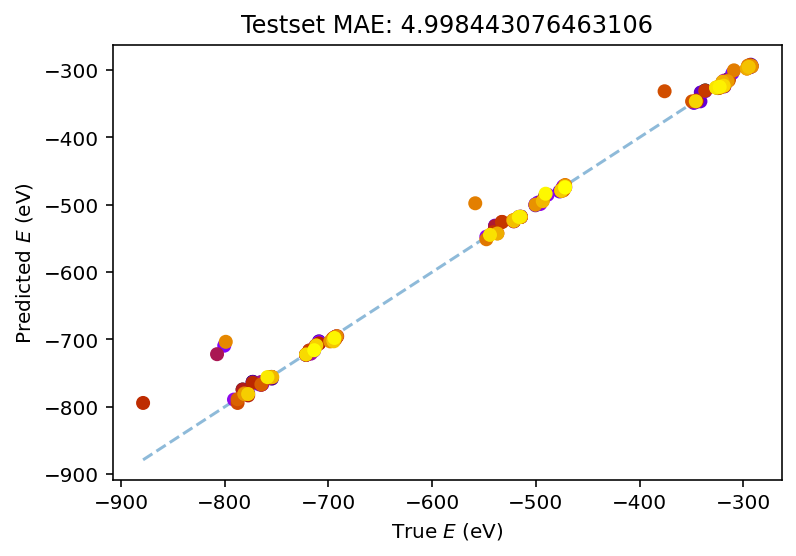

In [14]:
# import matplotlib.pyplot as plt
# %matplotlib inline
cmap = get_cmap(val_mol.__len__())
plt.plot([np.min(val_target), np.max(val_target)], [np.min(val_target), np.max(val_target)], '--', alpha=0.5, zorder=-1)
scatter = plt.scatter(val_target, predicted_tests, c=[cmap(i) for i in range(val_mol.__len__())])
# plt.legend(handles=scatter.legend_elements()[0], labels=val_defect_id,  bbox_to_anchor=(1,1))

plt.xlabel('True $E$ (eV)')
plt.ylabel('Predicted $E$ (eV)')
plt.title(f'Testset MAE: {np.abs(target-pred).mean()}')
plt.savefig('valid_all.png', dpi=192)
plt.show()

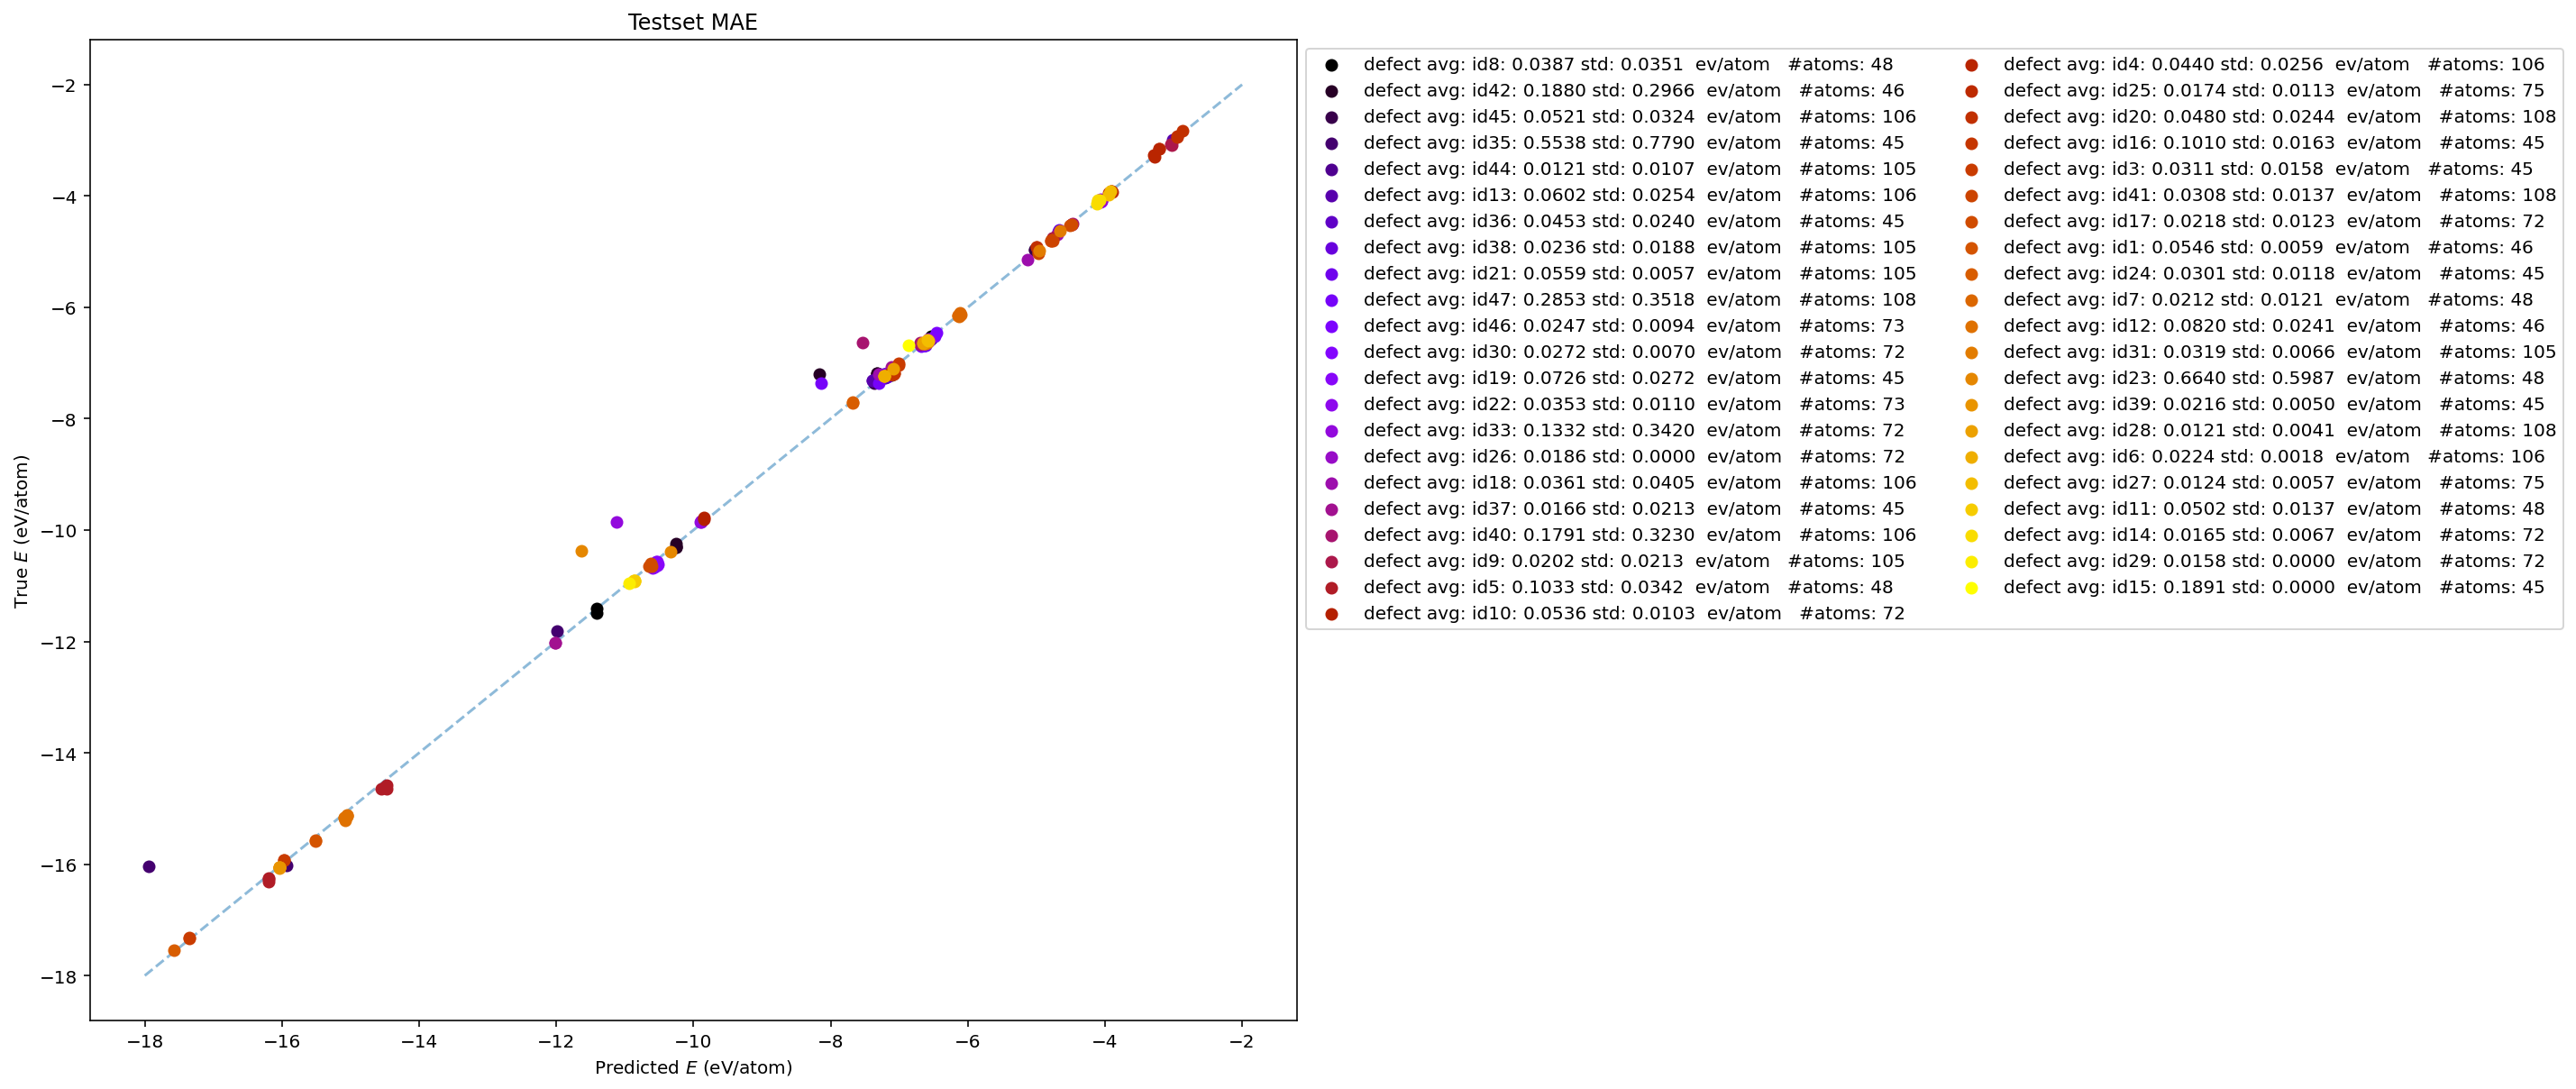

In [25]:
cmap = get_cmap(foo.items().__len__())

fig, axs = plt.subplots(figsize=(12, 10))
t1 = []
t2 = []
for i, ((k, v), mol) in enumerate(zip(foo.items(), val_mol)):
    color = color_label[''.join(['id', k])]
#     for target, pred in v:
    target = []
    pred = []
    for _target, _pred in v:
        target.append(_target)
        pred.append(_pred)
    target = np.array(target)/len(mol)
    pred = np.array(pred)/len(mol)

    _defect = (np.abs(target-pred))

    axs.scatter(target, pred, label=f'defect avg: id{k}: {np.mean(_defect).item():.4f} std: {np.std(_defect).item():.4f}  ev/atom   #atoms: {len(mol)}', color=cmap(i))
axs.plot([-18, -2], [-18, -2], '--', alpha=0.5, zorder=-1)     
legend_no_dup_labels(axs)

axs.set_title('Testset MAE')
axs.set_ylabel('True $E$ (eV/atom)')
axs.set_xlabel('Predicted $E$ (eV/atom)')
plt.savefig('valid_all_defects.png', dpi=192)


In [38]:
mol = []
target = []
defect_id = []
predicted = []
num_atoms = defaultdict(int)

    
for i, defect in enumerate(dataset.keys()):
    try:
        data_len = dataset[defect][0].__len__()
        [defect_id.append(defect) for j in range(data_len)]

        for realization in dataset[defect]:
            num_atoms[defect] = len(atoms)
            mol.append(pymatgen.io.ase.AseAtomsAdaptor.get_molecule(realization[0]))
            target.append(realization[-1].get_potential_energy())  
    except IndexError:
        print('ops')
        

for _mol, _target in zip(mol, target):
    pred = model.predict_structure(_mol).ravel()[0]
    predicted.append(pred)


In [49]:
len(predicted) == len(target)

True

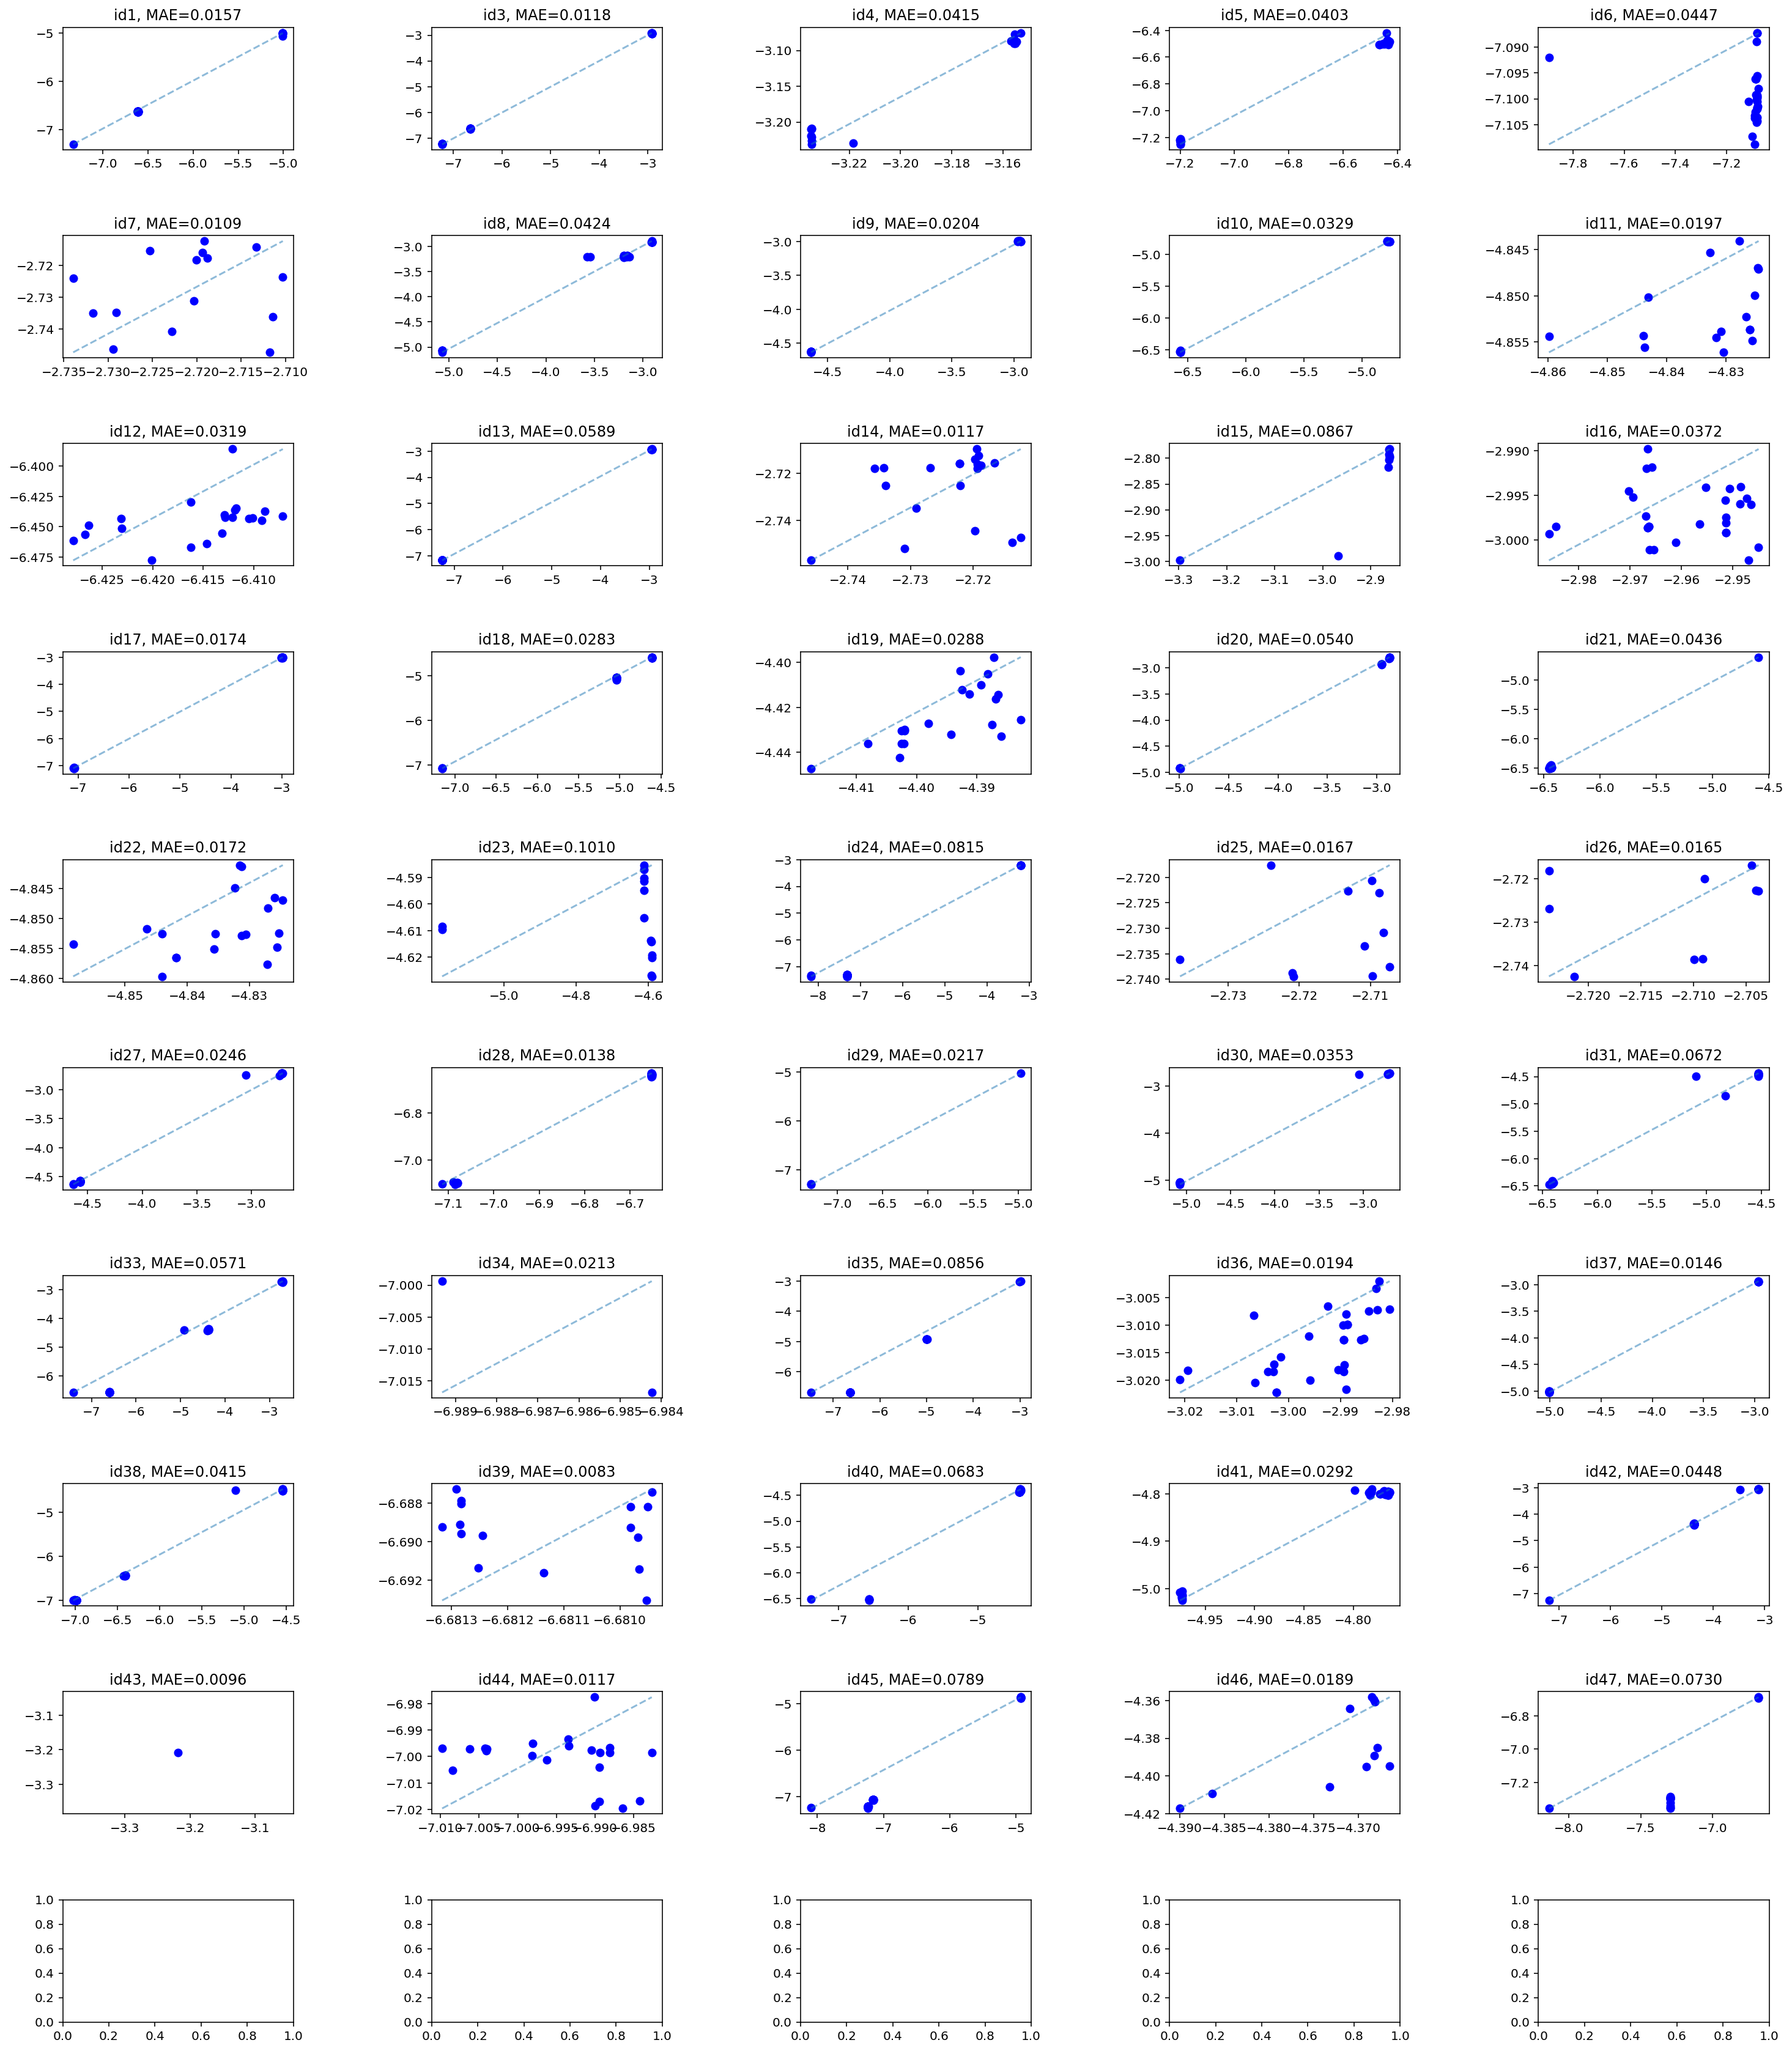

In [76]:
fig, axs = plt.subplots(10, 5, figsize=(25, 30), squeeze=False)

target_dict = defaultdict(list)
pred_dict = defaultdict(list)

for _target, _pred, id in zip(target, predicted, defect_id):
    target_dict[id].append(_target)
    pred_dict[id].append(_pred)

axs = axs.flatten()
i = 0
for id in sorted(set(defect_id), key=lambda x: int(x.strip('id'))):
    _target = np.array(target_dict[id]) / num_atoms[id]
    _pred = np.array(pred_dict[id]) / num_atoms[id]
    if len(_target) != 0:
        ax = axs[i]
        ax.scatter(_target, _pred, c='b')
        ax.set_title(f'{id}, MAE={np.abs(np.array(_target) - np.array(_pred)).mean():.04f}')
        if len(_target):
            xs = [np.min(_target) , np.max(_target)]
            ys = [np.min(_pred), np.max(_pred)]
            ax.plot(xs, ys, '--', alpha=0.5)
        i += 1

    
fig.subplots_adjust(hspace=0.7, wspace=0.6)

    